# Speech Feature Extraction using OpenSMILE (GeMapsv01b + ComParE config)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
from typing import List, Optional

import pandas as pd
from IPython.display import display
from tqdm.auto import tqdm
from scipy.io import wavfile
import numpy as np

sys.path.append("..")
# opensmile
import opensmile

from sgs_utils.path_conf import loc_data_dir, interim_speech_data_dir


# Extracting features

useful links:
* [opensmile config folder](https://github.com/audeering/opensmile/tree/v3.0.0/config)
* difference between GeMAPS versions [here](https://github.com/audeering/opensmile/blob/v3.0.0/config/gemaps/CHANGES.txt')

**note**: `eGeMAPS` is an _extended_ version of the GeMAPS

feature-level`
* `Functionals`: global segment based features (1 feature per segment)
* `LowLevelDescriptor`: sliding window features (1 feature per window)

In [3]:
df_session = pd.read_parquet(loc_data_dir.joinpath("df_session_tot_cleaned.parquet"))


In [4]:
(df_session.wav_duration_s < 25).value_counts()

False    2670
True      587
Name: wav_duration_s, dtype: int64

In [5]:
# define the feature extraction configs
func_gemaps = opensmile.Smile(
    feature_set=opensmile.FeatureSet.GeMAPSv01b,
    feature_level=opensmile.FeatureLevel.Functionals,
)


lld_gemaps = opensmile.Smile(
    feature_set=opensmile.FeatureSet.GeMAPSv01b,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)

# we will use the ComParE LLD to calculate frequency-based features on `F0final_sma`
lld_compare = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)

In [6]:
from functional import seq

seq(func_gemaps.feature_names).filter(
    lambda x: any(substr in x.lower() for substr in ["jitter", "shimmer"])
).to_list()


['jitterLocal_sma3nz_amean',
 'jitterLocal_sma3nz_stddevNorm',
 'shimmerLocaldB_sma3nz_amean',
 'shimmerLocaldB_sma3nz_stddevNorm']

In [7]:
from multiprocessing import Pool
import traceback
from typing import Tuple


### Whole file duration

In [8]:
def _extract_parse_smile_df(s: opensmile.Smile, f: Path) -> pd.DataFrame:
    df_feat = s.process_signal(np.load(f), sampling_rate=16_000, file=f)
    df_feat = df_feat.reset_index(drop=False)
    df_feat["file"] = df_feat["file"].astype("str")

    # df_feat["fileName"] = f.name
    df_feat["pic_name"] = f.name.split("__")[0]
    df_feat["time_str"] = f.name.split("__")[1].split(".")[0]
    df_feat["DB"] = f.parent.name
    df_feat["ID"] = f.parent.parent.name.split("__")[-1]
    return df_feat


def _extract_opensmile_f(file: Path) -> Tuple[pd.DataFrame, ...]:
    # calculate the global utterance features
    return (
        _extract_parse_smile_df(func_gemaps, f=file),
        _extract_parse_smile_df(lld_gemaps, f=file),
        _extract_parse_smile_df(lld_compare, f=file),
    )


out = None
with Pool(processes=8) as pool:
    npy_files = list(interim_speech_data_dir.glob("full_dur_16khz/*/*/*.npy"))[::10]
    results = pool.imap_unordered(_extract_opensmile_f, npy_files)
    results = tqdm(results, total=len(npy_files))
    try:
        out = [f for f in results]
    except:
        traceback.print_exc()
        pool.terminate()
    finally:
        pool.close()
        pool.join()


def _parse_concat_df(df_conc: pd.DataFrame) -> pd.DataFrame:
    df_conc["DB"] = df_conc["DB"].astype("category")
    df_conc["pic_name"] = df_conc["pic_name"].astype("category")
    df_conc["ID"] = df_conc["ID"].astype("category")
    return df_conc


df_gemaps_func = _parse_concat_df(pd.concat([o[0] for o in out], ignore_index=True))
df_gemaps_lld = _parse_concat_df(pd.concat([o[1] for o in out], ignore_index=True))
df_compare_lld = _parse_concat_df(pd.concat([o[2] for o in out], ignore_index=True))

del (
    out,
    _extract_opensmile_f,
    _parse_concat_df,
    _extract_parse_smile_df,
)


  0%|          | 0/3233 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 851, in next
    item = self._items.popleft()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipykernel_2006747/4256576454.py", line 29, in <module>
    out = [f for f in results]
  File "/tmp/ipykernel_2006747/4256576454.py", line 29, in <listcomp>
    out = [f for f in results]
  File "/home/jonas/.cache/pypoetry/virtualenvs/semi-guided-speech-27YL4uf1-py3.8/lib/python3.8/site-packages/tqdm/notebook.py", line 257, in __iter__
    for obj in super(tqdm_notebook, self).__iter__():
  File "/home/jonas/.cache/pypoetry/virtualenvs/semi-guided-speech-27YL4uf1-py3.8/lib/python3.8/site-packages/tqdm/std.py", line 1180, in __iter__
    for obj in iterable:
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 856, in next
    self._cond.wait(timeout)
  File "/usr/lib/python3.8/threading.py", l

TypeError: 'NoneType' object is not iterable

In [57]:
df_gem_ldd_utt = df_gemaps_lld[
    df_gemaps_lld.file == df_gemaps_lld.file.unique()[30]
].reset_index()


In [76]:
df_gemaps_lld[
    [
        "DB",
        "ID",
        "pic_name",
        "time_str",
        "start",
        "end",
        "F0semitoneFrom27.5Hz_sma3nz",
        "Loudness_sma3",
    ]
].to_parquet(loc_data_dir / "df_gemaps_lld_full_dur.parquet", engine="fastparquet")


<AxesSubplot:>

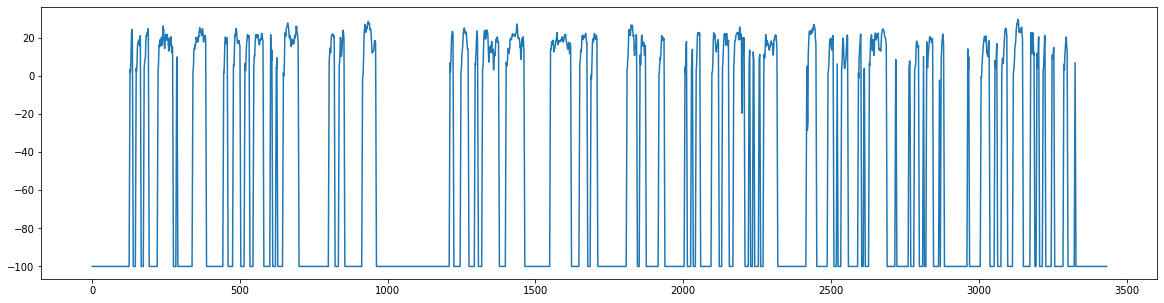

In [ ]:
df_comp_ldd_utt["logHNR_sma"].plot(figsize=(20, 5))


<AxesSubplot:>

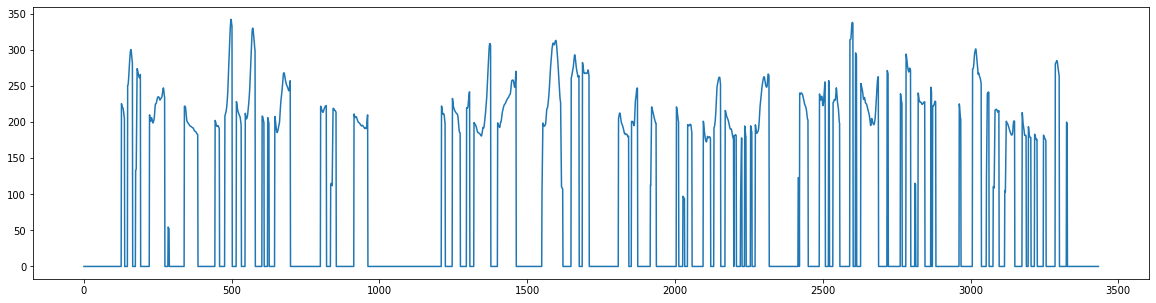

In [ ]:
df_comp_ldd_utt["F0final_sma"].plot(figsize=(20, 5))


In [77]:
df_compare_lld[
    ["DB", "ID", "pic_name", "time_str", "start", "end", "F0final_sma", "logHNR_sma"]
].to_parquet(loc_data_dir / "df_compare_lld_full_dur.parquet", engine="fastparquet")


### **Fixed** file duration

In [11]:
DURATION_S = 15


In [12]:
def _extract_parse_smile_duration(
    s: opensmile.Smile, f: Path, duration_s: float
) -> pd.DataFrame:
    sr, wav_arr = wavfile.read(f)

    # we extract features until the penultimate second of the utterance
    t_end = (wav_arr.shape[0] / sr) - 2
    t_start = max(1, t_end - duration_s)

    df_feat = s.process_signal(
        signal=np.load(str(f.absolute())),
        sampling_rate=16_000,
        file=f,
        start=t_start,
        end=t_end,
    )

    df_feat = df_feat.reset_index(drop=False)
    df_feat["file"] = df_feat["file"].astype(str)

    # df_feat["fileName"] = f.name
    df_feat["pic_name"] = f.name.split("__")[0]
    df_feat["time_str"] = f.name.split("__")[1].split(".")[0]
    df_feat["DB"] = f.parent.name
    df_feat["ID"] = f.parent.parent.name.split("__")[-1]
    return df_feat


def _extract_opensmile_f_duration(file_duration) -> Tuple[pd.DataFrame, ...]:
    file, duration = file_duration
    # calculate the global utterance features
    return (
        _extract_parse_smile_duration(func_gemaps, f=file, duration_s=duration),
        _extract_parse_smile_duration(lld_gemaps, f=file, duration_s=duration),
        _extract_parse_smile_duration(lld_compare, f=file, duration_s=duration),
    )


out = None
with Pool(processes=8) as pool:
    npy_files = list(interim_speech_data_dir.glob("full_dur_16khz_norm/*/*/*.npy"))
    npy_file = [(nf, DURATION_S) for nf in npy_files]
    results = pool.imap_unordered(_extract_opensmile_f_duration, npy_files)
    results = tqdm(results, total=len(npy_files))
    try:
        out = [f for f in results]
    except:
        traceback.print_exc()
        pool.terminate()
    finally:
        pool.close()
        pool.join()


def _parse_concat_df(df_conc: pd.DataFrame) -> pd.DataFrame:
    df_conc["DB"] = df_conc["DB"].astype("category")
    df_conc["pic_name"] = df_conc["pic_name"].astype("category")
    df_conc["ID"] = df_conc["ID"].astype("category")
    return df_conc


df_gemaps_func_dur = _parse_concat_df(pd.concat([o[0] for o in out], ignore_index=True))
df_gemaps_lld_dur = _parse_concat_df(pd.concat([o[1] for o in out], ignore_index=True))
df_compare_lld_dur = _parse_concat_df(pd.concat([o[2] for o in out], ignore_index=True))

del (
    out,
    _extract_opensmile_f_duration,
    _parse_concat_df,
    _extract_parse_smile_duration,
)


0it [00:00, ?it/s]

ValueError: No objects to concatenate

## Extract `F0`-range from the LLD's

In [22]:
import numpy as np
from tsflex.features import FuncWrapper
from tsflex.features.utils import make_robust


In [23]:
def quantile_nz(a: np.ndarray, q=List[float]) -> List[Optional[float]]:
    a_nz = a[a > 0]
    if len(a_nz):
        return np.quantile(a_nz, q=q)
    else:
        return [None] * len(q)


def std_nz(a: np.ndarray) -> Optional[float]:
    a_nz = a[a > 0]
    if len(a_nz):
        return np.std(a_nz)
    return None


def nonzero_count(a: np.ndarray) -> int:
    return sum(a > 0)


def return_func_series_list(a: np.ndarray, f_list: List[FuncWrapper]) -> pd.Series:
    s = pd.Series(dtype="float64")
    for f in f_list:
        s = pd.concat([s, pd.Series(data=f(a), index=f.output_names)])
    return s.sort_index()


qs = sum([[1 - q, q] for q in [0, 0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2]], []) + [0.5]
display(str(qs))


'[1, 0, 0.99, 0.01, 0.98, 0.02, 0.97, 0.03, 0.95, 0.05, 0.9, 0.1, 0.85, 0.15, 0.8, 0.2, 0.5]'

### GeMAPS LLD

#### Whole duration

In [24]:
df_gemaps_lld.filter(like="F0").columns
# logRelF0-H1-H2_sma3nz -> log freq difference between the harmonics
# SMA -> moving average window
# NZ -> no-zero


Index(['F0semitoneFrom27.5Hz_sma3nz', 'logRelF0-H1-H2_sma3nz',
       'logRelF0-H1-A3_sma3nz', 'F1amplitudeLogRelF0_sma3nz',
       'F2amplitudeLogRelF0_sma3nz', 'F3amplitudeLogRelF0_sma3nz'],
      dtype='object')

In [25]:
# define the signal on which the function will be performed, and the functions
s_name = "F0semitoneFrom27.5Hz_sma3nz"

f_gemaps_lld_funcs: List[FuncWrapper] = [
    make_robust(
        FuncWrapper(quantile_nz, output_names=[s_name + f"_q={q}" for q in qs], q=qs),
        min_nb_samples=3,
        passthrough_nans=False,
    ),
    make_robust(FuncWrapper(nonzero_count, output_names=[f"{s_name}_nzcount"])),
    make_robust(FuncWrapper(std_nz, output_names=[f"{s_name}_std"])),
]

# Apply the functions on each group
df_gemaps_lld_F0 = (
    df_gemaps_lld.groupby(by=["file"])[[s_name]]
    .apply(lambda x: return_func_series_list(x.values, f_list=f_gemaps_lld_funcs))
    .reset_index()
)
display(df_gemaps_lld_F0)


/tmp/ipykernel_45991/3620613513.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.concat([s, pd.Series(data=f(a), index=f.output_names)])
/tmp/ipykernel_45991/3620613513.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.concat([s, pd.Series(data=f(a), index=f.output_names)])
/tmp/ipykernel_45991/3620613513.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.concat([s, pd.Series(data=f(a), index=f.output_names)])
/tmp/ipykernel_45991/3620613513.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s =

,file,F0semitoneFrom27.5Hz_sma3nz_nzcount,F0semitoneFrom27.5Hz_sma3nz_q=0,F0semitoneFrom27.5Hz_sma3nz_q=0.01,F0semitoneFrom27.5Hz_sma3nz_q=0.02,F0semitoneFrom27.5Hz_sma3nz_q=0.03,F0semitoneFrom27.5Hz_sma3nz_q=0.05,F0semitoneFrom27.5Hz_sma3nz_q=0.1,F0semitoneFrom27.5Hz_sma3nz_q=0.15,F0semitoneFrom27.5Hz_sma3nz_q=0.2,F0semitoneFrom27.5Hz_sma3nz_q=0.5,F0semitoneFrom27.5Hz_sma3nz_q=0.8,F0semitoneFrom27.5Hz_sma3nz_q=0.85,F0semitoneFrom27.5Hz_sma3nz_q=0.9,F0semitoneFrom27.5Hz_sma3nz_q=0.95,F0semitoneFrom27.5Hz_sma3nz_q=0.97,F0semitoneFrom27.5Hz_sma3nz_q=0.98,F0semitoneFrom27.5Hz_sma3nz_q=0.99,F0semitoneFrom27.5Hz_sma3nz_q=1,F0semitoneFrom27.5Hz_sma3nz_std
0,/media/speech_webapp_cleaned/backup/2020-11-26...,5606.0,12.251042,13.934838,14.599903,14.984331,15.436341,16.219905,19.077585,21.401300,23.277583,25.690542,26.900887,27.558018,28.568579,32.494460,34.903307,35.731693,60.804386,4.560182
1,/media/speech_webapp_cleaned/backup/2020-11-26...,6669.0,12.058680,13.842417,14.423253,14.856564,15.276927,16.208848,19.443033,21.618110,23.451925,26.041262,26.716160,27.476436,28.203361,29.057006,31.833231,35.101993,60.076370,4.228516
2,/media/speech_webapp_cleaned/backup/2020-11-26...,5844.0,12.202407,13.778239,14.236030,14.644257,15.155413,16.168508,19.076534,21.514988,23.319512,25.941892,26.545710,27.309220,27.936713,30.257185,33.922007,35.548235,60.912628,4.578349
3,/media/speech_webapp_cleaned/backup/2020-11-26...,8443.0,12.125778,13.991558,14.645151,14.944079,15.383024,15.988630,17.458601,20.491598,23.273064,25.555413,26.574199,27.526564,28.037846,29.437154,32.693497,35.109045,60.835857,4.559110
4,/media/speech_webapp_cleaned/backup/2020-11-26...,6159.0,12.189971,13.662513,14.442118,14.943714,15.459200,17.056338,20.813693,22.235821,23.349960,25.271851,26.260371,27.144308,28.023798,29.963233,31.603961,35.470180,60.711689,4.181477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3255,/media/speech_webapp_cleaned/backup/2022-07-29...,1207.0,12.081606,12.333227,14.234591,15.495650,16.751472,17.717968,18.184064,18.838248,30.589996,34.799860,35.623919,36.578542,37.130973,37.724056,38.851741,39.343193,59.869705,7.346724
3256,/media/speech_webapp_cleaned/backup/2022-07-29...,1147.0,12.122270,12.416688,12.569788,12.722285,13.154190,16.428841,16.939161,17.635229,30.006018,33.042439,33.739609,35.319817,36.723486,37.391315,38.017653,61.607289,62.090675,8.707480
3257,/media/speech_webapp_cleaned/backup/2022-07-29...,1129.0,12.099364,12.852855,13.356646,14.185842,15.858899,16.714621,17.751991,18.508284,30.441248,33.191100,34.591146,35.719296,37.349375,38.074427,38.498878,39.238436,60.109604,7.307754
3258,/media/speech_webapp_cleaned/backup/2022-07-29...,1178.0,12.042550,12.434628,12.837402,13.191461,15.476952,16.605111,17.161470,17.578321,30.261019,33.462995,34.710780,35.625403,36.458971,36.714640,37.069306,37.830679,61.561722,7.605315


#### Fixed duration

In [26]:
# define the signal on which the function will be performed, and the functions
s_name = "F0semitoneFrom27.5Hz_sma3nz"

f_gemaps_lld_funcs: List[FuncWrapper] = [
    make_robust(
        FuncWrapper(quantile_nz, output_names=[s_name + f"_q={q}" for q in qs], q=qs),
        min_nb_samples=3,
        passthrough_nans=False,
    ),
    make_robust(FuncWrapper(nonzero_count, output_names=[f"{s_name}_nzcount"])),
    make_robust(FuncWrapper(std_nz, output_names=[f"{s_name}_std"])),
]

# Apply the functions on each group
df_gemaps_lld_F0_dur = (
    df_gemaps_lld_dur.groupby(by=["file"])[[s_name]]
    .apply(lambda x: return_func_series_list(x.values, f_list=f_gemaps_lld_funcs))
    .reset_index()
)
display(df_gemaps_lld_F0_dur)


/tmp/ipykernel_45991/3620613513.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.concat([s, pd.Series(data=f(a), index=f.output_names)])
/tmp/ipykernel_45991/3620613513.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.concat([s, pd.Series(data=f(a), index=f.output_names)])
/tmp/ipykernel_45991/3620613513.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.concat([s, pd.Series(data=f(a), index=f.output_names)])
/tmp/ipykernel_45991/3620613513.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s =

,file,F0semitoneFrom27.5Hz_sma3nz_nzcount,F0semitoneFrom27.5Hz_sma3nz_q=0,F0semitoneFrom27.5Hz_sma3nz_q=0.01,F0semitoneFrom27.5Hz_sma3nz_q=0.02,F0semitoneFrom27.5Hz_sma3nz_q=0.03,F0semitoneFrom27.5Hz_sma3nz_q=0.05,F0semitoneFrom27.5Hz_sma3nz_q=0.1,F0semitoneFrom27.5Hz_sma3nz_q=0.15,F0semitoneFrom27.5Hz_sma3nz_q=0.2,F0semitoneFrom27.5Hz_sma3nz_q=0.5,F0semitoneFrom27.5Hz_sma3nz_q=0.8,F0semitoneFrom27.5Hz_sma3nz_q=0.85,F0semitoneFrom27.5Hz_sma3nz_q=0.9,F0semitoneFrom27.5Hz_sma3nz_q=0.95,F0semitoneFrom27.5Hz_sma3nz_q=0.97,F0semitoneFrom27.5Hz_sma3nz_q=0.98,F0semitoneFrom27.5Hz_sma3nz_q=0.99,F0semitoneFrom27.5Hz_sma3nz_q=1,F0semitoneFrom27.5Hz_sma3nz_std
0,/media/speech_webapp_cleaned/backup/2020-11-26...,1112.0,13.122096,13.881085,14.458974,14.795674,15.216663,15.972083,17.301385,20.665640,22.753908,25.771634,26.573505,27.369186,27.826359,28.527192,30.504682,34.926117,53.513889,4.343889
1,/media/speech_webapp_cleaned/backup/2020-11-26...,1127.0,13.436420,14.259380,14.596902,15.005586,15.441089,17.921014,20.968177,21.876841,23.418358,26.029682,27.012871,27.780138,28.776328,33.891972,34.911347,35.400385,36.192989,3.927652
2,/media/speech_webapp_cleaned/backup/2020-11-26...,1172.0,12.402657,13.938350,14.342841,15.038761,15.733745,19.174141,21.439508,21.971087,23.340619,25.576147,26.428004,27.317442,29.821573,33.787843,35.250256,38.547446,60.687878,4.352689
3,/media/speech_webapp_cleaned/backup/2020-11-26...,1092.0,13.689807,14.412113,14.758807,15.102302,15.521777,16.088668,17.827491,20.116849,22.925423,25.858927,27.142988,27.746759,27.930443,28.057064,28.556473,34.381355,60.852364,4.735933
4,/media/speech_webapp_cleaned/backup/2020-11-26...,1232.0,12.271514,13.210986,14.377844,14.960424,15.906208,20.281139,22.154643,22.488363,23.584784,26.338916,26.927075,27.533591,28.011135,28.523093,29.330261,34.209718,35.575684,3.395312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3255,/media/speech_webapp_cleaned/backup/2022-07-29...,525.0,12.111890,13.325765,14.097616,15.764285,17.097023,17.760195,19.265684,20.329132,31.001776,35.056116,35.562463,36.620591,37.576349,38.889307,39.313846,39.500855,59.869705,7.338382
3256,/media/speech_webapp_cleaned/backup/2022-07-29...,454.0,12.122270,12.328709,12.565002,12.851870,13.138999,16.619678,16.980999,17.301708,30.335692,33.014997,34.022290,35.801359,37.544811,61.093627,61.491940,61.853252,62.090675,9.630668
3257,/media/speech_webapp_cleaned/backup/2022-07-29...,491.0,12.099364,12.526840,12.922506,13.069245,15.476135,16.882950,17.974790,19.255781,30.717026,34.006207,34.631210,35.820171,38.155293,38.973419,39.279740,39.621155,60.109604,7.522724
3258,/media/speech_webapp_cleaned/backup/2022-07-29...,504.0,12.042550,12.310602,12.436391,12.527343,12.898826,16.023402,16.838290,17.499307,30.053848,34.070846,35.092982,35.892273,36.452871,36.661359,37.243609,37.556779,61.561722,8.075009


### ComPaRE LLD

#### whole duration

In [27]:
df_compare_lld.filter(like="F0").columns


Index(['F0final_sma'], dtype='object')

In [28]:
s_name = "F0final_sma"

f_compare_lld_funcs: List[FuncWrapper] = [
    make_robust(
        FuncWrapper(quantile_nz, output_names=[s_name + f"_q={q}" for q in qs], q=qs),
        min_nb_samples=3,
        passthrough_nans=False,
    ),
    make_robust(FuncWrapper(nonzero_count, output_names=[f"{s_name}_nzcount"])),
    make_robust(FuncWrapper(std_nz, output_names=[f"{s_name}_std"])),
]

df_compare_lld_F0 = (
    df_compare_lld.groupby(by=["file"])[[s_name]]
    .apply(lambda x: return_func_series_list(x.values, f_list=f_compare_lld_funcs))
    .reset_index()
)
display(df_compare_lld_F0)


/tmp/ipykernel_45991/3620613513.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.concat([s, pd.Series(data=f(a), index=f.output_names)])
/tmp/ipykernel_45991/3620613513.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.concat([s, pd.Series(data=f(a), index=f.output_names)])
/tmp/ipykernel_45991/3620613513.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.concat([s, pd.Series(data=f(a), index=f.output_names)])
/tmp/ipykernel_45991/3620613513.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s =

,file,F0final_sma_nzcount,F0final_sma_q=0,F0final_sma_q=0.01,F0final_sma_q=0.02,F0final_sma_q=0.03,F0final_sma_q=0.05,F0final_sma_q=0.1,F0final_sma_q=0.15,F0final_sma_q=0.2,F0final_sma_q=0.5,F0final_sma_q=0.8,F0final_sma_q=0.85,F0final_sma_q=0.9,F0final_sma_q=0.95,F0final_sma_q=0.97,F0final_sma_q=0.98,F0final_sma_q=0.99,F0final_sma_q=1,F0final_sma_std
0,/media/speech_webapp_cleaned/backup/2020-11-26...,5622.0,52.298656,56.101261,60.085774,62.776053,65.467890,68.991801,78.506369,92.523997,105.082005,120.209875,129.159807,134.972649,141.894171,175.935077,204.956156,215.498943,565.227539,35.059998
1,/media/speech_webapp_cleaned/backup/2020-11-26...,6730.0,52.114815,54.945571,58.684430,61.011790,63.963683,68.100830,76.856810,92.588599,106.166687,123.597900,128.654580,134.670850,140.508255,147.329590,176.243254,208.560956,610.042847,34.364635
2,/media/speech_webapp_cleaned/backup/2020-11-26...,5888.0,52.275314,56.059643,59.288075,61.171159,63.938275,68.366886,77.650687,93.083754,105.533138,122.905286,127.358680,133.092166,138.208298,159.549930,194.637052,214.173433,616.529541,37.066652
3,/media/speech_webapp_cleaned/backup/2020-11-26...,8482.0,52.261513,58.112240,61.698209,63.786730,65.865573,68.787999,73.208767,89.024400,105.371071,120.390477,127.811561,134.904288,138.900650,150.584442,181.465928,208.894098,569.968994,34.705423
4,/media/speech_webapp_cleaned/backup/2020-11-26...,6184.0,52.103363,56.152028,59.095276,61.117693,64.470763,69.215200,84.403019,97.940027,105.715275,117.944487,125.116856,131.648111,138.539454,153.763796,167.430952,206.614407,546.310913,31.341312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3255,/media/speech_webapp_cleaned/backup/2022-07-29...,1228.0,52.411278,53.939654,54.771486,55.353274,61.848297,74.720444,77.771447,80.506860,159.513138,204.224112,213.104485,226.435313,233.289359,241.514572,251.894667,265.805937,273.261505,56.675216
3256,/media/speech_webapp_cleaned/backup/2022-07-29...,1204.0,52.487247,53.634017,54.127582,54.430317,55.368380,58.189675,70.085032,72.434044,150.905098,183.427542,188.064606,202.630594,222.311356,229.543662,232.635621,239.594741,253.532104,55.602199
3257,/media/speech_webapp_cleaned/backup/2022-07-29...,1163.0,52.773777,54.031909,55.025267,56.056439,58.569788,71.208409,73.127590,78.411322,157.588943,185.448474,201.357944,215.537708,235.859216,246.316853,253.116634,261.448510,273.304169,54.954997
3258,/media/speech_webapp_cleaned/backup/2022-07-29...,1203.0,52.260334,54.205374,55.671660,56.428998,58.888730,71.055174,72.906142,75.434706,157.304367,188.512646,202.498245,214.416791,225.505159,228.730060,232.307007,241.654327,480.455841,56.908717


In [ ]:
del df_compare_lld, df_gemaps_lld


#### Fixed duration

In [29]:
s_name = "F0final_sma"

f_compare_lld_funcs: List[FuncWrapper] = [
    make_robust(
        FuncWrapper(quantile_nz, output_names=[s_name + f"_q={q}" for q in qs], q=qs),
        min_nb_samples=3,
        passthrough_nans=False,
    ),
    make_robust(FuncWrapper(nonzero_count, output_names=[f"{s_name}_nzcount"])),
    make_robust(FuncWrapper(std_nz, output_names=[f"{s_name}_std"])),
]

df_compare_lld_F0_dur = (
    df_compare_lld_dur.groupby(by=["file"])[[s_name]]
    .apply(lambda x: return_func_series_list(x.values, f_list=f_compare_lld_funcs))
    .reset_index()
)
display(df_compare_lld_F0_dur)


/tmp/ipykernel_45991/3620613513.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.concat([s, pd.Series(data=f(a), index=f.output_names)])
/tmp/ipykernel_45991/3620613513.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.concat([s, pd.Series(data=f(a), index=f.output_names)])
/tmp/ipykernel_45991/3620613513.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.concat([s, pd.Series(data=f(a), index=f.output_names)])
/tmp/ipykernel_45991/3620613513.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s =

,file,F0final_sma_nzcount,F0final_sma_q=0,F0final_sma_q=0.01,F0final_sma_q=0.02,F0final_sma_q=0.03,F0final_sma_q=0.05,F0final_sma_q=0.1,F0final_sma_q=0.15,F0final_sma_q=0.2,F0final_sma_q=0.5,F0final_sma_q=0.8,F0final_sma_q=0.85,F0final_sma_q=0.9,F0final_sma_q=0.95,F0final_sma_q=0.97,F0final_sma_q=0.98,F0final_sma_q=0.99,F0final_sma_q=1,F0final_sma_std
0,/media/speech_webapp_cleaned/backup/2020-11-26...,1110.0,52.515720,59.550177,61.644557,63.415400,65.251291,68.541936,71.334982,86.079478,101.478558,120.907774,127.066941,133.397832,137.053220,144.247558,164.291497,207.567622,605.024841,36.802723
1,/media/speech_webapp_cleaned/backup/2020-11-26...,1137.0,52.169254,58.053143,60.028618,61.909581,64.787181,69.921494,88.439491,96.671332,106.136009,122.955678,129.919092,136.964676,143.642413,175.066255,203.429737,211.766790,214.966629,26.602538
2,/media/speech_webapp_cleaned/backup/2020-11-26...,1184.0,52.456104,54.270726,58.549653,61.314212,64.047336,73.038348,91.204002,96.796397,105.504154,119.886519,126.595753,133.235713,157.287839,193.613500,210.703262,259.345192,611.399170,39.907779
3,/media/speech_webapp_cleaned/backup/2020-11-26...,1097.0,52.258652,57.555002,61.642259,63.632233,65.603233,68.605052,70.291788,82.021001,102.886314,120.972205,131.653961,136.536163,138.035153,139.013577,142.655715,199.030864,616.790710,41.025275
4,/media/speech_webapp_cleaned/backup/2020-11-26...,1232.0,52.972012,57.447994,60.514348,63.565456,67.601669,88.101160,97.584045,100.475096,107.414379,126.072002,130.589661,135.145366,139.316591,142.847991,151.438947,199.253249,214.674286,21.754796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3255,/media/speech_webapp_cleaned/backup/2022-07-29...,537.0,52.411278,53.815871,54.473767,55.182697,58.448596,74.618364,79.244200,86.137927,161.384293,207.541605,212.280011,226.131650,235.083456,250.921192,261.007480,266.620685,273.261505,56.058366
3256,/media/speech_webapp_cleaned/backup/2022-07-29...,484.0,52.487247,53.489115,53.905257,54.274060,54.706801,56.499628,60.450850,72.390379,150.863167,183.178098,185.703445,198.102008,221.243517,231.749359,238.248474,245.759638,253.532104,56.461768
3257,/media/speech_webapp_cleaned/backup/2022-07-29...,513.0,52.773777,53.723000,54.336057,54.840268,56.111498,65.511383,72.927167,78.666809,159.579422,192.413712,201.826782,212.936194,247.267242,254.604106,262.980389,268.844015,273.304169,57.112913
3258,/media/speech_webapp_cleaned/backup/2022-07-29...,512.0,53.005619,53.948271,54.624933,55.173694,56.416730,62.703044,72.016611,74.807172,155.291420,196.385416,208.469205,217.509985,225.339508,228.183186,235.059670,237.844198,480.455841,60.560208


In [ ]:
# df_compare_lld_F0_dur['F0final_sma_nzcount'].value_counts()


# Join into one big dataframe

## Whole duration

In [33]:
df_feat_tot = df_gemaps_func.merge(
    df_gemaps_lld_F0,
    on=["file"],
).merge(df_compare_lld_F0, on=["file"])

display(df_feat_tot)

df_feat_tot.to_parquet(
    loc_data_dir.joinpath("df_speech_feat_tot.parquet"), engine="fastparquet"
)


,file,start,end,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,...,F0final_sma_q=0.5,F0final_sma_q=0.8,F0final_sma_q=0.85,F0final_sma_q=0.9,F0final_sma_q=0.95,F0final_sma_q=0.97,F0final_sma_q=0.98,F0final_sma_q=0.99,F0final_sma_q=1,F0final_sma_std
0,/media/speech_webapp_cleaned/backup/2020-11-26...,0 days,0 days 00:00:22.198276644,24.007944,0.188660,21.448441,24.165707,27.310490,5.862049,157.721634,...,110.520576,133.204330,136.023117,139.648880,149.287903,155.091446,159.195297,180.676071,261.382050,26.145859
1,/media/speech_webapp_cleaned/backup/2020-11-26...,0 days,0 days 00:00:23.777233560,23.863079,0.182161,21.644140,23.963394,27.131609,5.487469,240.555115,...,109.708603,131.763046,134.549557,138.171005,147.095493,173.905411,204.944672,212.089901,407.436768,31.185211
2,/media/speech_webapp_cleaned/backup/2020-11-26...,0 days,0 days 00:00:22.012517007,24.547234,0.143577,22.476704,25.052620,27.208073,4.731369,182.949905,...,116.787682,132.347961,135.697220,141.367798,147.934433,152.668022,154.929968,162.721475,213.333603,22.587254
3,/media/speech_webapp_cleaned/backup/2020-11-26...,0 days,0 days 00:00:25.263310657,24.599348,0.179130,21.967764,25.141613,27.766148,5.798384,222.906677,...,117.441856,136.731186,139.141769,144.537766,151.755722,162.659708,167.707507,181.804877,582.304810,35.289525
4,/media/speech_webapp_cleaned/backup/2020-11-26...,0 days,0 days 00:00:21.640997732,24.023479,0.170988,21.722029,24.118435,26.866180,5.144152,215.788132,...,110.648407,129.929474,133.913681,138.832230,147.923180,155.662360,159.461169,179.427890,604.380737,32.479560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3255,/media/speech_webapp_cleaned/backup/2022-07-29...,0 days,0 days 00:00:28.672000,26.589331,0.297268,18.324661,30.316681,32.568565,14.243904,328.664276,...,156.845360,179.256882,186.111668,196.893204,209.769741,220.269680,229.243279,242.962517,287.092896,53.060605
3256,/media/speech_webapp_cleaned/backup/2022-07-29...,0 days,0 days 00:00:29.866666667,27.538448,0.273330,18.692644,30.333893,33.564602,14.871958,225.533112,...,156.914352,188.514206,196.826084,207.765968,222.409668,229.993871,242.759653,261.307195,279.645294,56.203512
3257,/media/speech_webapp_cleaned/backup/2022-07-29...,0 days,0 days 00:00:34.730666667,30.063257,0.253081,23.187132,31.525269,34.239147,11.052015,300.031616,...,168.417877,192.828931,204.019978,217.283932,245.481996,267.474963,278.823220,296.340424,342.739563,56.406376
3258,/media/speech_webapp_cleaned/backup/2022-07-29...,0 days,0 days 00:00:30.549333333,29.029013,0.245755,21.882660,30.907600,33.051300,11.168640,374.068726,...,163.306297,183.499384,191.505323,199.296135,215.745352,221.694379,263.348202,273.055754,499.169189,52.317964


## Fixed duration

In [34]:
df_feat_tot_dur = df_gemaps_func_dur.merge(
    df_gemaps_lld_F0_dur,
    on=["file"],
).merge(df_compare_lld_F0_dur, on=["file"])

display(df_feat_tot_dur)

df_feat_tot_dur.to_parquet(
    loc_data_dir.joinpath(f"df_speech_feat_tot_{DURATION_S}s.parquet"),
    engine="fastparquet",
)


,file,start,end,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,...,F0final_sma_q=0.5,F0final_sma_q=0.8,F0final_sma_q=0.85,F0final_sma_q=0.9,F0final_sma_q=0.95,F0final_sma_q=0.97,F0final_sma_q=0.98,F0final_sma_q=0.99,F0final_sma_q=1,F0final_sma_std
0,/media/speech_webapp_cleaned/backup/2020-11-26...,0 days 00:00:00,0 days 00:00:09.820498866,24.239685,0.197734,21.465519,24.568817,27.071358,5.605839,164.067108,...,113.018311,131.158914,135.485562,140.365036,154.196330,159.312083,168.390383,199.963067,604.380737,42.406215
1,/media/speech_webapp_cleaned/backup/2020-11-26...,0 days 00:00:00,0 days 00:00:10.099138322,23.929838,0.226161,21.023754,24.046206,27.551891,6.528137,187.470551,...,109.989197,135.128052,138.201920,143.146164,149.917130,153.857654,156.913052,196.515714,261.382050,29.029921
2,/media/speech_webapp_cleaned/backup/2020-11-26...,0 days 00:00:00,0 days 00:00:11.631655329,24.491964,0.209518,20.766779,24.849165,27.832775,7.065996,270.519897,...,115.703796,137.047739,140.613589,146.052365,160.558090,165.840691,178.470654,375.313575,582.304810,45.648519
3,/media/speech_webapp_cleaned/backup/2020-11-26...,0 days 00:00:00,0 days 00:00:10.006258503,24.363800,0.149572,22.219257,24.683170,27.130074,4.910816,164.576767,...,114.378471,131.793457,135.502396,141.114517,147.558517,153.772034,154.565555,160.630338,213.333603,22.949861
4,/media/speech_webapp_cleaned/backup/2020-11-26...,0 days 00:00:00,0 days 00:00:10.888616780,24.334663,0.196280,21.857309,24.649261,27.470707,5.613398,359.110016,...,113.053253,134.071762,137.082139,145.200926,152.648600,201.115561,205.246506,212.750762,407.436768,36.997951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3255,/media/speech_webapp_cleaned/backup/2022-07-29...,0 days 00:00:00,0 days 00:00:13.933333333,28.138924,0.262838,19.160347,31.739861,33.588272,14.427925,196.351608,...,171.155106,189.764621,195.777077,204.598672,211.460495,222.457440,236.238565,265.332869,272.520050,55.636780
3256,/media/speech_webapp_cleaned/backup/2022-07-29...,0 days 00:00:00,0 days 00:00:13.336000,27.315117,0.283532,18.290337,30.543329,33.412140,15.121803,193.817444,...,158.235748,188.038403,198.451437,204.818040,216.968382,229.354390,244.414448,270.704076,287.092896,55.441265
3257,/media/speech_webapp_cleaned/backup/2022-07-29...,0 days 00:00:01.365333333,0 days 00:00:16.365333333,30.677828,0.252255,24.055370,31.893747,34.709621,10.654251,179.117371,...,171.572083,201.461716,208.563187,229.595581,263.805341,273.710258,279.181036,288.200612,341.743896,59.520005
3258,/media/speech_webapp_cleaned/backup/2022-07-29...,0 days 00:00:00.768000,0 days 00:00:15.768000,30.371105,0.222629,25.565237,32.238106,33.837151,8.271914,237.301773,...,175.540901,193.481689,197.513123,214.686882,242.040451,264.340080,272.734589,283.056671,317.864655,56.384059


---

In [ ]:
df_feat_tot["file"].map(lambda x: "/".join(x.split("/")[-3:]))


In [ ]:
df_feat_tot[["file", "DB", "pic_name", "time_str", "ID"]]
